In [1]:
import cv2
import os
import numpy as np

def load_and_preprocess_images_from_directory(directory, target_shape):
    image_list = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.endswith(".jpg"):
                img = cv2.imread(os.path.join(root, filename))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, target_shape)  # Resize to the target shape
                image_list.append(img)
    return image_list

target_shape = (256, 256)

# Load grayscale and color images from directories with subfolders
grayscale_images = load_and_preprocess_images_from_directory("bw_output/", target_shape)
color_images = load_and_preprocess_images_from_directory("color_input/", target_shape)
print(len(color_images))

# Convert grayscale images to single-channel format
grayscale_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in grayscale_images]

# Expand the dimensions of grayscale images to match the model input
grayscale_images = [np.expand_dims(img, axis=-1) for img in grayscale_images]

# Example: Ensure that the color images are in RGB format
for i, img in enumerate(color_images):
    if img.shape[2] == 1:
        # If color images are in grayscale, convert them to RGB
        color_images[i] = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

# Expand the dimensions of color images to match the model input
color_images = [np.expand_dims(img, axis=-1) for img in color_images]

904


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_colorization_model():
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    
    # Decoder
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    
    # Output layer with 3 channels (RGB)
    model.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    
    return model

In [3]:
import tensorflow as tf

model = create_colorization_model()

def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile the model with the updated loss function
model.compile(optimizer='adam', loss=custom_loss)

In [4]:
import numpy as np

# train the model on grayscale and coloured images
model.fit(np.array(grayscale_images), np.array(color_images), epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
23/23 [==============================] - 121s 5s/step - loss: 19522.0234 - val_loss: 14517.6270
Epoch 2/10
23/23 [==============================] - 148s 6s/step - loss: 19516.7832 - val_loss: 14517.6270
Epoch 3/10
23/23 [==============================] - 147s 6s/step - loss: 19516.7852 - val_loss: 14517.6270
Epoch 4/10
23/23 [==============================] - 143s 6s/step - loss: 19516.7871 - val_loss: 14517.6270
Epoch 5/10
23/23 [==============================] - 137s 6s/step - loss: 19516.7832 - val_loss: 14517.6260
Epoch 6/10
23/23 [==============================] - 128s 6s/step - loss: 19516.7852 - val_loss: 14517.6260
Epoch 7/10
23/23 [==============================] - 124s 5s/step - loss: 19516.7852 - val_loss: 14517.6260
Epoch 8/10
23/23 [==============================] - 119s 5s/step - loss: 19516.7852 - val_loss: 14517.6230
Epoch 9/10
23/23 [==============================] - 122s 5s/step - loss: 19516.7852 - val_loss: 14517.6211
Epoch 10/10
23/23 [==================

In [5]:
import tensorflow as tf

# Save the trained model
model.save('models/colorization_model.keras')

In [6]:
import cv2
import numpy as np
import tensorflow as tf

# Define your custom loss function
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Load the model and specify the custom loss function
trained_model = tf.keras.models.load_model('models/colorization_model.keras', custom_objects={'custom_loss': custom_loss})

# Load your grayscale image
grayscale_image = cv2.imread('bw_output/Lion/1.jpg', cv2.IMREAD_GRAYSCALE)

# Preprocess the grayscale image
grayscale_image = cv2.resize(grayscale_image, (256, 256))  # Resize to match the model input size
grayscale_image = grayscale_image / 255.0  # Normalize to [0, 1] if needed

# Expand the dimensions of the grayscale image to match the model input
grayscale_image = np.expand_dims(grayscale_image, axis=-1)

# Generate color prediction
color_prediction = trained_model.predict(np.array([grayscale_image]))

# Post-process the color image
color_image = (color_prediction[0] * 255).astype(np.uint8)

# Display or save the color image
cv2.imwrite('colorized_image.jpg', color_image)

1/1 [==============================] - 0s 177ms/step


True

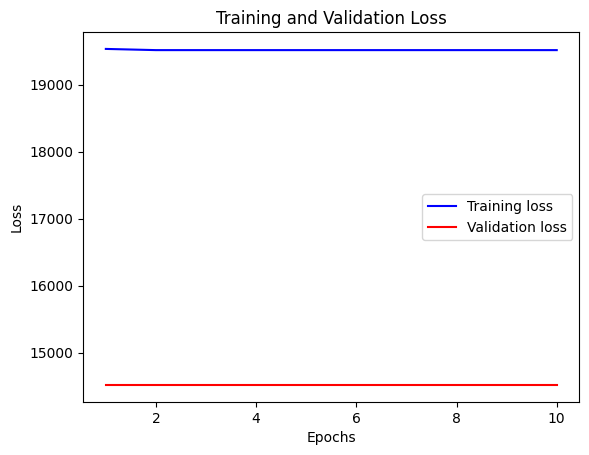

In [7]:
import matplotlib.pyplot as plt

# Example data
train_loss = [19534.6484, 19516.7852, 19516.7852, 19516.7852, 19516.7852, 19516.7852, 19516.7852, 19516.7852, 19516.7852, 19516.7832]
val_loss = [14517.6270, 14517.6270, 14517.6270, 14517.6270, 14517.6270, 14517.6270, 14517.6270, 14517.6270, 14517.6270, 14517.6270]

# Create a range of epochs for x-axis
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

In [10]:
import tensorflow as tf

# The first dimension has size 1, indicating that there is only one example in the batch.
# The second and third dimensions have size 256, indicating the height and width of the tensor.
# The fourth dimension has size 1, indicating that there is only one channel (e.g., grayscale)
input_data = tf.random.normal((1, 256, 256, 1))
output_shape = model.compute_output_shape(input_data.shape)

# Count the number of parameters
num_params = model.count_params()

# Assuming each parameter requires 2 FLOPs (input and output)
flops = 2 * num_params

print(f"Number of Parameters: {num_params}")
print(f"Estimated FLOPs: {flops}")

Number of Parameters: 39299
Estimated FLOPs: 78598


In [5]:
# Parameters for each layer
conv2d_params = 640
max_pooling2d_params = 0
conv2d_transpose_params = 36928
up_sampling2d_params = 0
conv2d_1_params = 1731

# Input size for each layer
input_size = 256 * 256 * 1

# Output size for each layer
output_size_conv2d = 256 * 256 * 64
output_size_max_pooling2d = 128 * 128 * 64
output_size_conv2d_transpose = 128 * 128 * 64
output_size_up_sampling2d = 256 * 256 * 64
output_size_conv2d_1 = 256 * 256 * 3

# FLOPs for each layer
flops_conv2d = 2 * input_size * output_size_conv2d * conv2d_params
flops_max_pooling2d = 2 * output_size_conv2d * output_size_max_pooling2d * max_pooling2d_params
flops_conv2d_transpose = 2 * output_size_max_pooling2d * output_size_conv2d_transpose * conv2d_transpose_params
flops_up_sampling2d = 2 * output_size_conv2d_transpose * output_size_up_sampling2d * up_sampling2d_params
flops_conv2d_1 = 2 * output_size_up_sampling2d * output_size_conv2d_1 * conv2d_1_params

total_flops = flops_conv2d + flops_max_pooling2d + flops_conv2d_transpose + flops_up_sampling2d + flops_conv2d_1

print(f"Total number of compuatations: {total_flops}")

Total number of compuatations: 84412256443432960


In [4]:
# generating the number of parameters at each step
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.square(y_true - y_pred))

model = load_model('models/colorization_model.keras', custom_objects={'custom_loss': custom_loss})

model.summary()
total_flops = flops_conv2d + flops_max_pooling2d + flops_conv2d_transpose + flops_up_sampling2d + flops_conv2d_1

print(f"Total number of compuatations: {total_flops}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_transpose (Conv2DTr  (None, 128, 128, 64)      36928     
 anspose)                                                        
                                                                 
 up_sampling2d (UpSampling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 3)       1731      
                                                        